In [1]:
import os
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scprep
import numpy as np
from scipy.sparse import csr_matrix
from tqdm import tqdm
import scprep
from sklearn.utils.extmath import randomized_svd
from sklearn.kernel_approximation import RBFSampler
from sklearn.random_projection import GaussianRandomProjection

In [2]:
from pyplink import PyPlink
#import tqdm
import phate
from sklearn.decomposition import PCA, KernelPCA

os.chdir('../../src')
import mappings
import data_loader

In [3]:
# Load HGDP
exp_path = '/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4'
fname = 'gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnet'
data_path = os.path.join(exp_path, fname)

pedfile = PyPlink(data_path)

In [4]:
all_samples = pedfile.get_fam()
all_samples.head()

,fid,iid,father,mother,gender,status
0,CHMI_CHMI3_WGS2,CHMI_CHMI3_WGS2,0,0,0,-9
1,HG00096,HG00096,0,0,0,-9
2,HG00097,HG00097,0,0,0,-9
3,HG00099,HG00099,0,0,0,-9
4,HG00100,HG00100,0,0,0,-9


In [5]:
all_markers = pedfile.get_bim()
all_markers.head()

,chrom,pos,cm,a1,a2
snp,,,,,
1:858952:G:A,1,858952,0,A,G
1:905373:T:C,1,905373,0,C,T
1:911428:C:T,1,911428,0,T,C
1:918870:A:G,1,918870,0,G,A
1:931513:T:C,1,931513,0,C,T


In [6]:
try:
    genotypes_array = np.load(exp_path + '_raw_genotypes.npy')
except:
    genotypes_array = np.zeros([pedfile.get_nb_samples(), pedfile.get_nb_markers()], dtype=np.int8)

    for i, (marker_id, genotypes) in tqdm.tqdm(enumerate(pedfile)):
        genotypes_array[:,i] = genotypes

    np.save(exp_path + '_raw_genotypes.npy', genotypes_array)

In [7]:
genotypes_array = genotypes_array[1:] # remove first row

In [8]:
labels = pd.read_csv(os.path.join(exp_path, 'gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.reduced.tsv'), sep='\t')
labels = labels[1:] # remove first row

# Load filter data
filter_info = pd.read_csv(os.path.join(exp_path, '4.3/gnomad_derived_metadata_with_filtered_sampleids.csv'), sep=',', index_col=1)

merged_metadata = labels.set_index('sample').merge(filter_info, left_index=True, right_index=True)

# load relatedness
relatedness = pd.read_csv(os.path.join(exp_path, '4.3/HGDP+1KGP_MattEstimated_king_relatedness_matrix.csv'), sep=',', index_col=0)
cols_to_filter = relatedness.index[(~merged_metadata.loc[relatedness.index]['filter_king_related']).values].values
relatedness_none_related = relatedness[(~merged_metadata.loc[relatedness.index]['filter_king_related']).values][cols_to_filter]

## Helper Functions

In [9]:
def make_palette_label_order_HGDP(populations, superpopulations):
    # SAS -> CSA + add MID, OCE
    pop_palette_hgdp_coarse = copy.deepcopy(mappings.pop_pallette_1000G_coarse)
    pop_palette_hgdp_coarse['CSA'] = mappings.pop_pallette_1000G_coarse['SAS']
    pop_palette_hgdp_coarse.pop('SAS')

    pop_palette_hgdp_coarse['MID'] = 'grey'
    pop_palette_hgdp_coarse['OCE'] = 'yellow'

    label_order_hgdp_coarse = copy.deepcopy(mappings.label_order_1000G_coarse)
    label_order_hgdp_coarse.remove('SAS')
    label_order_hgdp_coarse += ['CSA', 'MID', 'OCE']

    # Keep original 24/26 populations (with colors), and add new ones. New pops colored using superpop
    label_order_hgdp_fine = []
    for super_pop in np.unique(superpopulations):
        for pop in np.unique(populations[superpopulations==super_pop]):
            label_order_hgdp_fine.append(pop)

    # create tmp object to hold the original 26 populations
    mapping_26 = copy.deepcopy(mappings.pop_pallette_1000G_fine)
    mapping_26['GBR'] = mapping_26['CEUGBR']
    mapping_26['CEU'] = mapping_26['CEUGBR']
    mapping_26['STU'] = mapping_26['STUITU']
    mapping_26['ITU'] = mapping_26['STUITU']

    pop_palette_hgdp_fine = {}

    for super_pop in np.unique(superpopulations):
        for pop in np.unique(populations[superpopulations==super_pop]):
            if pop not in mapping_26.keys():
                # just use superpop color for now
                pop_palette_hgdp_fine[pop] = pop_palette_hgdp_coarse[super_pop]
            else:
                pop_palette_hgdp_fine[pop] = mapping_26[pop]

    return pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine

pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(merged_metadata['Population'],
                                                                                                                               merged_metadata['Genetic_region'])

In [10]:
def replace_negative_one_with_nan(array):
    # Replace all occurrences of -1 with np.nan
    return np.where(array == -1, np.nan, array)

def compute_non_missing_overlap(non_missing_mask, save_path="non_missing_overlap.npz"):
    # Check if the result already exists
    if os.path.exists(save_path):
        print("Loading previously computed non-missing overlap matrix...")
        return np.load(save_path)['overlap_matrix']

    # Convert non-missing mask to sparse format, treating False as 1 and True as 0
    sparse_mask = csr_matrix((~non_missing_mask).astype(int))

    # Initialize a list to store row-wise results
    results = []

    # Iterate over each row with tqdm for progress tracking
    for i in tqdm(range(sparse_mask.shape[0]), desc="Computing row-wise non-missing overlaps"):
        # Compute addition of row `i` with all rows in `sparse_mask`
        replicated_row = vstack([sparse_mask[i]] * sparse_mask.shape[0])

        # Count non-zero entries for each pair (row i + row j)
        nonzero_counts = (replicated_row+sparse_mask).getnnz(axis=1)

        # Append the non-zero counts as a sparse row to results
        results.append(nonzero_counts)

    # Stack all the result rows to form the final matrix
    final_result = np.vstack(results)
    final_result = len(non_missing_mask[0]) - final_result
    np.savez_compressed(save_path, overlap_matrix=final_result)

    return final_result

def hwe_normalize(genotypes_array):

    # Compute allele frequencies, ignoring NaNs
    allele_freqs = np.nanmean(genotypes_array / 2, axis=0)  # p = mean allele frequency

    # Center the matrix by subtracting 2 * allele frequency for each SNP
    centered_matrix = genotypes_array - 2 * allele_freqs

    # Compute Hardy-Weinberg variance for each SNP, avoiding division by zero
    hwe_variance = 2 * allele_freqs * (1 - allele_freqs)
    hwe_variance[hwe_variance == 0] = 1  # Avoid division by zero for monomorphic SNPs

    # Normalize each SNP by Hardy-Weinberg variance
    normalized_matrix = centered_matrix / np.sqrt(hwe_variance)
    return normalized_matrix

def preprocess_data_matrix(genotypes_array):
    
    # Compute hwe normalized matrix
    genotypes_array = replace_negative_one_with_nan(genotypes_array)
    normalized_matrix = hwe_normalize(genotypes_array)

    # Create a mask for non-missing values
    non_missing_mask = ~np.isnan(genotypes_array)

    # Replace NaNs in the normalized matrix with zeros for compatibility with matrix multiplication
    normalized_matrix = np.where(non_missing_mask, normalized_matrix, 0)

    # speeds up computation by exploiting sparsity
    overlap_counts = compute_non_missing_overlap(non_missing_mask)
    assert np.allclose(overlap_counts[:2], np.dot(non_missing_mask[0:2].astype(int), non_missing_mask.T))    
    return normalized_matrix, overlap_counts

In [11]:
def approximate_kernel_random_projection(normalized_matrix, n_components=2000):
    projector = GaussianRandomProjection(n_components=n_components, random_state=42)
    reduced_genotype_matrix = projector.fit_transform(normalized_matrix)
    kernel_approx = reduced_genotype_matrix @ reduced_genotype_matrix.T
    return kernel_approx

def select_top_variance_snps(genotype_matrix, top_k=5000):
    # Compute variance across SNPs
    variances = np.var(genotype_matrix, axis=0)
    
    # Select top-k SNPs with the highest variance
    top_snp_indices = np.argsort(variances)[-top_k:]
    reduced_genotype_matrix = genotype_matrix[:, top_snp_indices]
    
    return reduced_genotype_matrix

# Compute a kernel on the reduced genotype matrix
def approximate_kernel_top_variance_snps(genotype_matrix, top_k=5000):
    reduced_genotype_matrix = select_top_variance_snps(genotype_matrix, top_k)
    kernel_approx = reduced_genotype_matrix @ reduced_genotype_matrix.T
    return kernel_approx

def compute_kernel_matrix(normalized_matrix, 
                          overlap_counts, 
                          approx='random_projection',
                          scale_by_overlap=True):

    if approx == 'random_projection':
        gram_approx = approximate_kernel_random_projection(normalized_matrix)
    elif approx == 'top_variance':
        gram_approx = approximate_kernel_top_variance_snps(normalized_matrix)
    elif approx == 'exact':
        gram_approx = normalized_matrix @ normalized_matrix.T

    #gt = normalized_matrix@normalized_matrix[0]
    #plt.scatter(gt, gram_approx1[:,0])
    #plt.xlim(-50000, 50000)
    #plt.ylim(-50000, 50000)
    
    if scale_by_overlap:
        gsm = gram_approx/overlap_counts
    else:
        gsm = gram_approx
    
    return gsm

def compute_pca_from_data_matrix(data,
                                 to_fit_on,
                                 to_transform_on,
                                 n_components=50):
    pca_emb = np.zeros((len(gsm), n_components))
    
    # SVD of data matrix (usual sklearn PCA implementation)
    pca_obj = PCA(n_components=n_components)
    pca_obj.fit(data[to_fit_on])

    # Transform on both
    pca_emb[to_fit_on] = pca_obj.transform(data[to_fit_on])
    pca_emb[to_transform_on] = pca_obj.transform(data[to_transform_on])
    return pca_emb, pca_obj

def compute_pca_from_kernel(gsm,
                            to_fit_on,
                            to_transform_on,
                            n_components=50):

    # Eigendecomposing kernel matrix

    # Step 1: Perform eigenvalue decomposition on the unrelated kernel subset
    eigenvalues, eigenvectors = np.linalg.eigh(gsm[to_fit_on, :][:, to_fit_on])

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices][:n_components]  # Select top NUM_PCS
    eigenvectors = eigenvectors[:, sorted_indices][:, :n_components]  # Select top NUM_PCS

    # Create PCA input matrix for all individuals
    pca_input = np.zeros((len(gsm), n_components))

    # Step 2: Project unrelated individuals into PCA space
    pca_input[to_fit_on] = eigenvectors * np.sqrt(eigenvalues)

    # Step 3: Project related individuals using the Nystrom extension
    kernel_related_unrelated = gsm[np.ix_(to_fit_on, to_transform_on)]
    pca_input[to_transform_on] = kernel_related_unrelated.T @ (eigenvectors / np.sqrt(eigenvalues + 1e-12))
    return pca_input, None

def compute_phate(pca_input, to_fit_on, to_transform_on, knn=5, t=5):
    phate_emb = np.zeros((len(pca_input), 2))

    # Step 4: Run PHATE on PCA-reduced data
    phate_operator = phate.PHATE(random_state=42, knn=knn, t=t, n_pca=None)
    
    # Fit PHATE on either the filtered unrelated or all data, based on phate_fit_related
    phate_operator.fit(pca_input[to_fit_on, :])
    
    # Transform all filtered individuals using PHATE embedding
    phate_emb[to_fit_on] = phate_operator.transform(pca_input[to_fit_on, :])
    phate_emb[to_transform_on] = phate_operator.transform(pca_input[to_transform_on, :])
    
    return phate_emb

def plot_pca_phate(pca_emb, phate_emb, indices_to_plot):
    # Visualization
    fig, ax = plt.subplots(figsize=(20, 10), ncols=2, gridspec_kw={'wspace': 0.08})

    # PCA plot
    scprep.plot.scatter2d(
        pca_emb[indices_to_plot, :2],
        s=20,
        cmap=pop_palette_hgdp_fine,
        ax=ax[0],
        c=merged_metadata[indices_to_plot]['Population'].values,
        xticks=False,
        yticks=False,
        legend=True,
        legend_loc='lower center',
        legend_anchor=(0.5, -0.35),
        legend_ncol=8,
        label_prefix="PCA ",
        fontsize=8
    )
    ax[0].set_title("PCA of HGDP", fontsize=30)
    ax[0].get_legend().remove()

    # PHATE plot
    scprep.plot.scatter2d(
        phate_emb[indices_to_plot, :],
        s=20,
        cmap=pop_palette_hgdp_fine,
        ax=ax[1],
        c=merged_metadata[indices_to_plot]['Population'].values,
        xticks=False,
        yticks=False,
        legend=True,
        legend_loc='lower center',
        legend_anchor=(0.5, -0.35),
        legend_ncol=8,
        label_prefix="PHATE ",
        fontsize=8
    )
    ax[1].set_title("PHATE of HGDP", fontsize=30)

In [12]:
def plot_pca_phate_data_matrix(data,
                               fit_indices,
                               transform_indices,
                               fit_phate_on_both_sets=True):
    pca_emb, pca_obj = compute_pca_from_data_matrix(data,
                                           fit_indices,
                                           transform_indices,
                                           n_components=50)
    
    plot_set = fit_indices | transform_indices
    if fit_phate_on_both_sets:
        phate_fit_set = phate_trans_set = plot_set
    else:
        phate_fit_set = fit_indices
        phate_trans_set = transform_indices
        
    phate_emb = compute_phate(pca_emb, phate_fit_set, phate_trans_set, knn=5, t=5)
    plot_pca_phate(pca_emb, phate_emb, plot_set)
    return pca_emb, pca_obj
    
def plot_pca_phate_kernel_matrix(gsm,
                                 fit_indices,
                                 transform_indices,
                                 fit_phate_on_both_sets=True):
    pca_emb, _ = compute_pca_from_kernel(gsm,
                                      fit_indices,
                                      transform_indices,
                                      n_components=50)

    plot_set = fit_indices | transform_indices
    if fit_phate_on_both_sets:
        phate_fit_set = phate_trans_set = plot_set
    else:
        phate_fit_set = fit_indices
        phate_trans_set = transform_indices

    phate_emb = compute_phate(pca_emb, phate_fit_set, phate_trans_set, knn=5, t=5)
    plot_pca_phate(pca_emb, phate_emb, plot_set)
    return pca_emb, None

In [13]:
# Step 0: Pre-process data
normalized_matrix, overlap_counts = preprocess_data_matrix(genotypes_array)

# Step 1: Compute Kernel Matrix
gsm = compute_kernel_matrix(normalized_matrix, 
                            overlap_counts, 
                            approx='random_projection',
                            scale_by_overlap=True)    

Loading previously computed non-missing overlap matrix...


In [14]:
# Fit PCA model on unrelated samples
filters = ["filter_pca_outlier", "hard_filtered", "filter_contaminated"]
_filtered_indices = merged_metadata[merged_metadata[filters].any(axis=1)].index
filtered_indices = ~merged_metadata.index.isin(_filtered_indices)
related_indices = ~merged_metadata['filter_king_related'].values #np.ones(shape=genotypes_array.shape[0], dtype=bool)

to_fit_on = related_indices & filtered_indices
to_transform_on = (~related_indices) & filtered_indices

Running PHATE on 4094 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.35 seconds.
  Calculating affinities...
  Calculated affinities in 0.05 seconds.
Calculated graph and diffusion operator in 0.44 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.18 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.55 seconds.
Calculated landmark operator in 3.46 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.96 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.01 seconds.


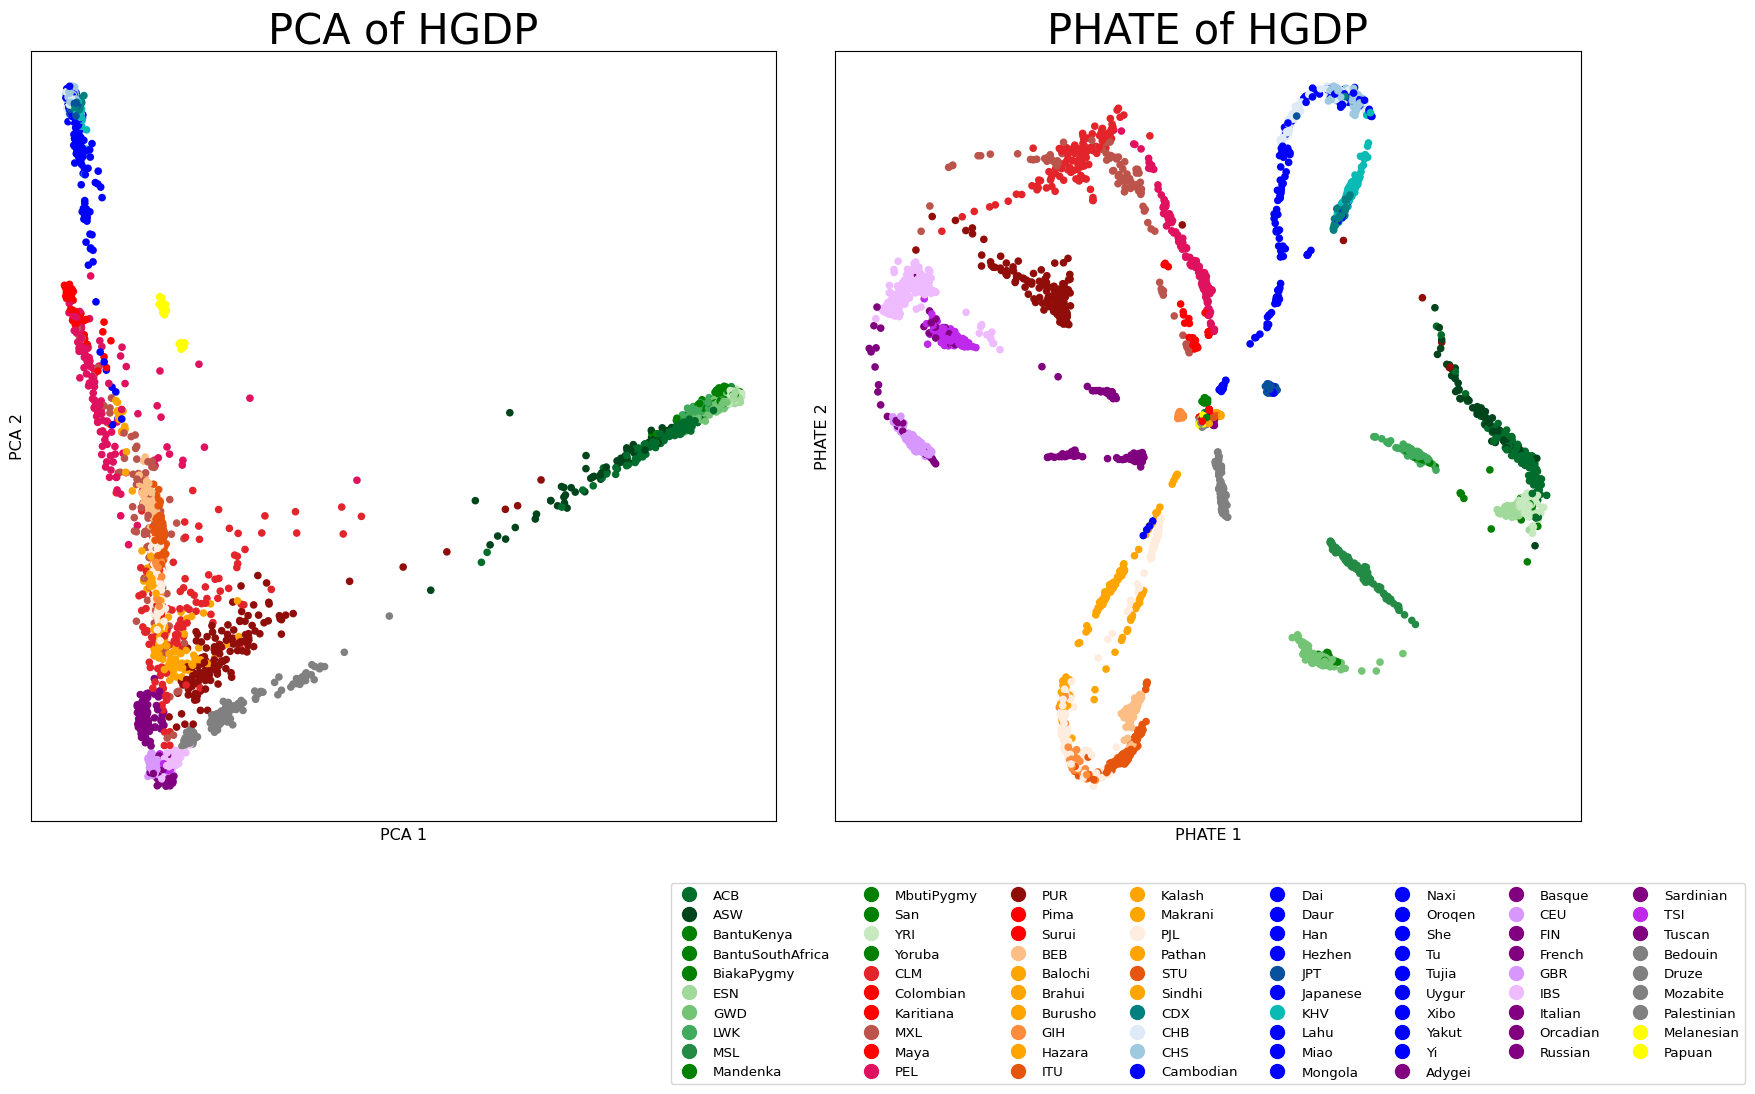

In [15]:
pca_emb, pca_obj = plot_pca_phate_data_matrix(normalized_matrix,
                                              to_fit_on,
                                              to_transform_on,
                                              fit_phate_on_both_sets=True)

Running PHATE on 4094 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.56 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.58 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.21 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.32 seconds.
Calculated landmark operator in 2.27 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.96 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.05 seconds.


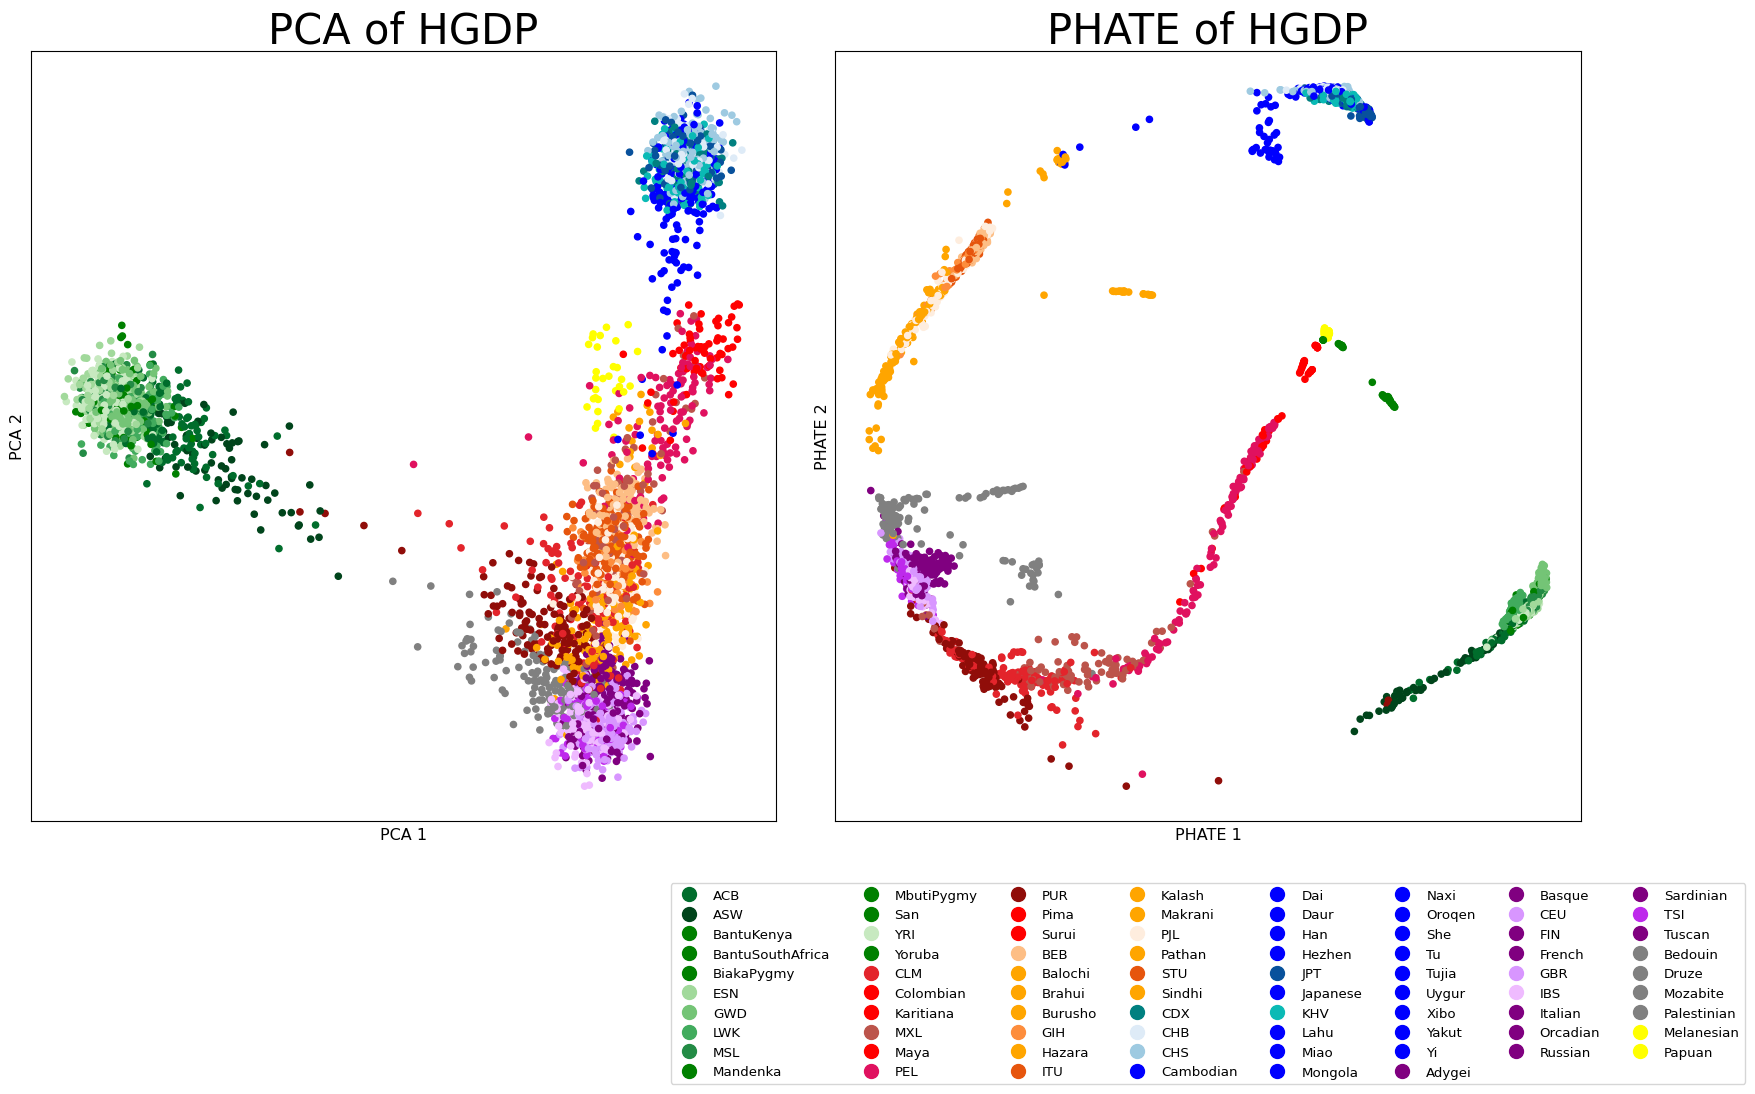

In [16]:
pca_emb_kernel, _ = plot_pca_phate_kernel_matrix(gsm,
                                                 to_fit_on,
                                                 to_transform_on,
                                                 fit_phate_on_both_sets=True)

Running PHATE on 4094 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.56 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.58 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.21 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.54 seconds.
Calculated landmark operator in 2.49 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.97 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.05 seconds.


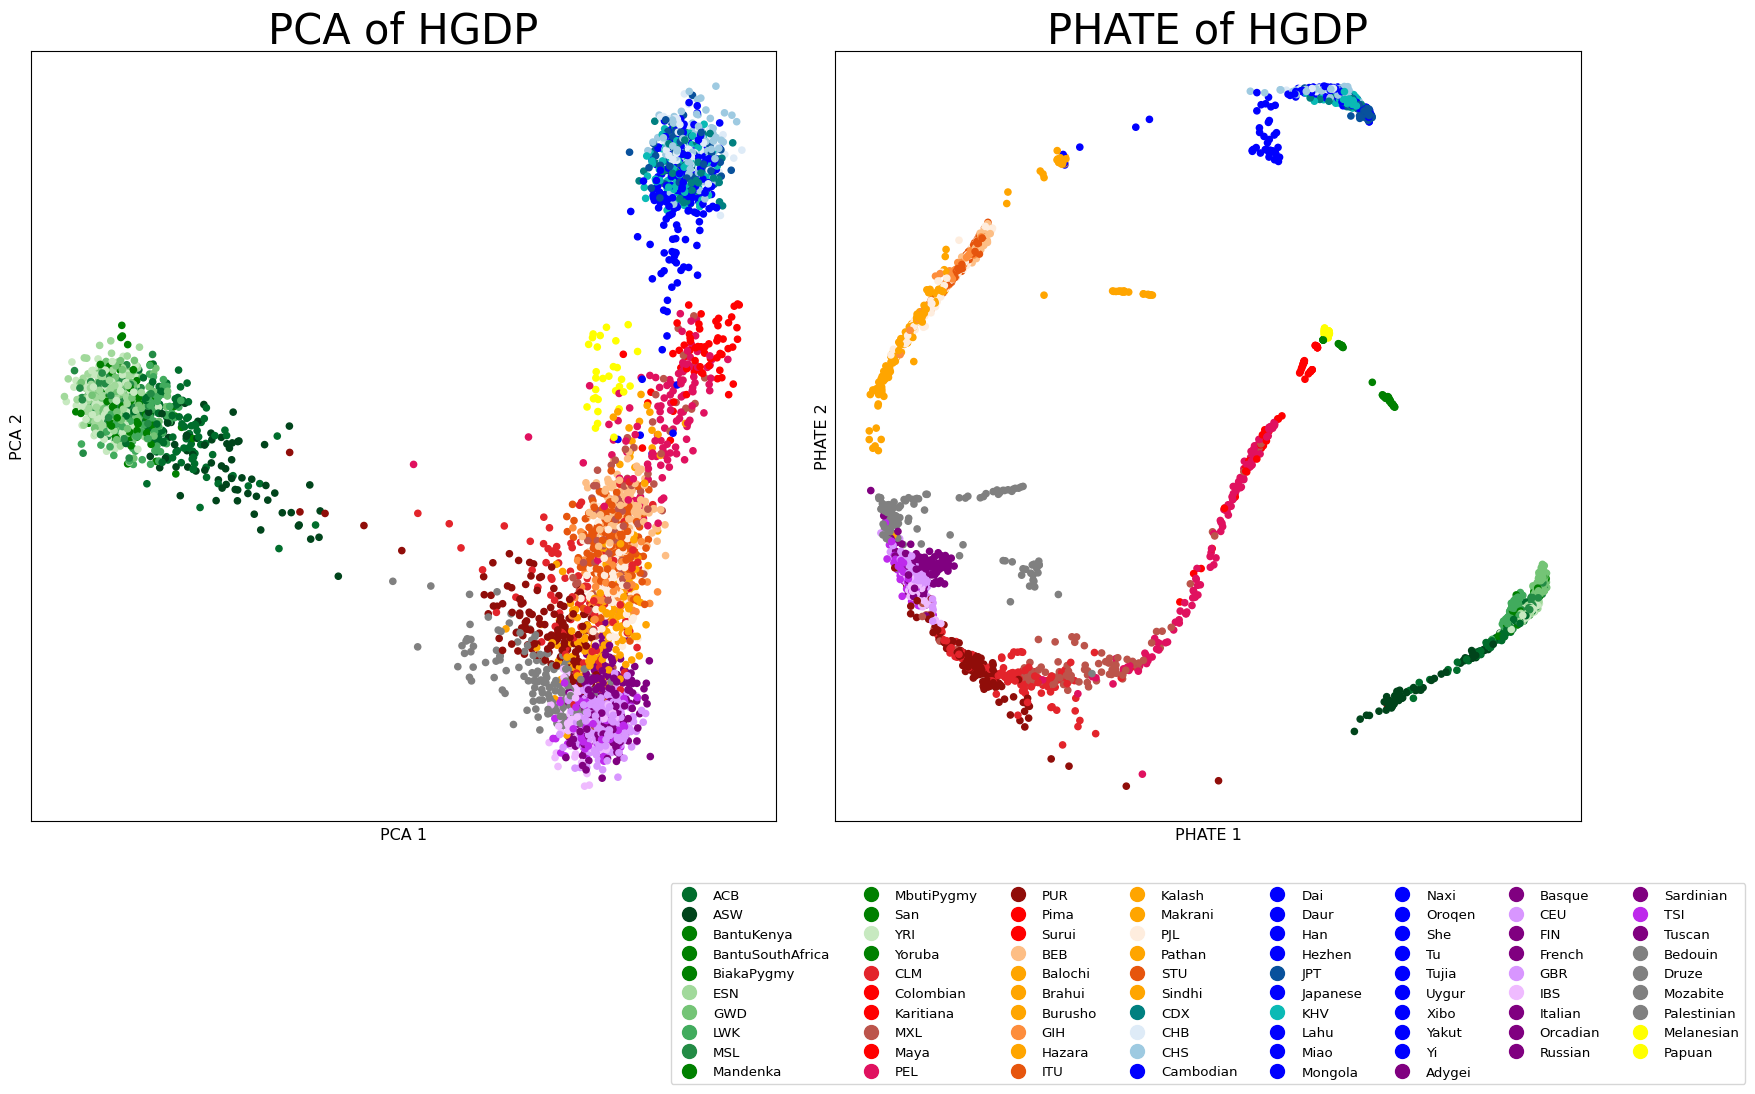

In [17]:
# Run PHATE on kernel approx:
phate_emb_approx = compute_phate(pca_emb_kernel, to_fit_on | to_transform_on, to_fit_on | to_transform_on)
plot_pca_phate(pca_emb_kernel, phate_emb_approx, to_fit_on | to_transform_on)

In [18]:
# load relatedness
relatedness = pd.read_csv(os.path.join(exp_path, '4.3/HGDP+1KGP_MattEstimated_king_relatedness_matrix.csv'), sep=',', index_col=0)

In [19]:
# Make same size as gsm (fill empty values as 0)
king_mat_filters = ["hard_filtered", "filter_contaminated"]
_king_mat_filtered_indices = merged_metadata[merged_metadata[king_mat_filters].any(axis=1)].index
king_mat_filtered_indices = ~merged_metadata.index.isin(_king_mat_filtered_indices)

relatedness_reindex = relatedness.loc[merged_metadata.index[king_mat_filtered_indices], merged_metadata.index[king_mat_filtered_indices]]

In [20]:
relatedness_reindex = relatedness_reindex.values.clip(0)**(1/5)

relatedness_full_mat = np.zeros_like(gsm)
relatedness_full_mat[np.ix_(king_mat_filtered_indices, king_mat_filtered_indices)] = relatedness_reindex

Running PHATE on 4094 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.66 seconds.
  Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 4620 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated affinities in 0.66 seconds.
Calculated graph and diffusion operator in 1.34 seconds.
Calculating landmark operator...
  Calculating SVD...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


  Calculated SVD in 0.57 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.39 seconds.
Calculated landmark operator in 3.81 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.93 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.90 seconds.


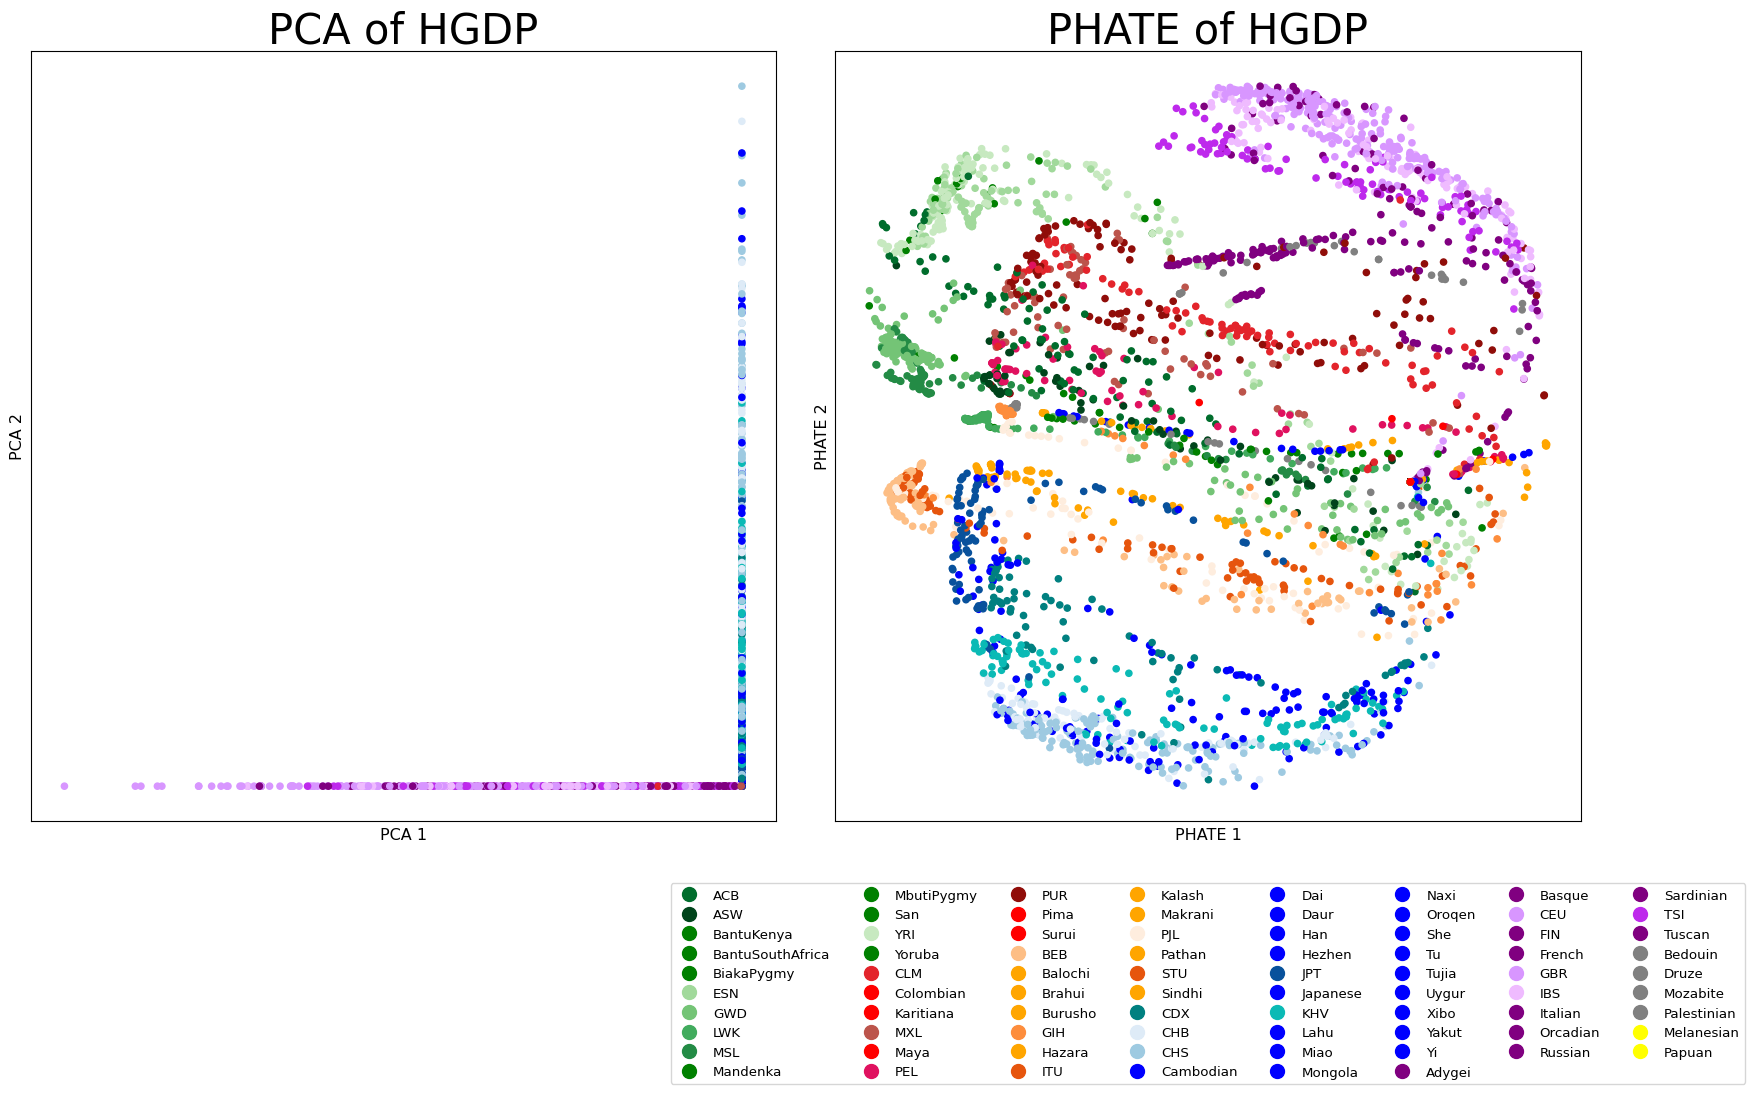

In [21]:
pca_emb_kernel, _ = plot_pca_phate_kernel_matrix(relatedness_full_mat,
                                                 to_fit_on,
                                                 to_transform_on,
                                                 fit_phate_on_both_sets=True)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 4117 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.26 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.64 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.56 seconds.
  Calculated landmark operator in 4.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.98 seconds.
  Calculating metric MDS...
    Using SMACOF because SGD returned NaN


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 8.83 seconds.
Calculated PHATE in 14.09 seconds.


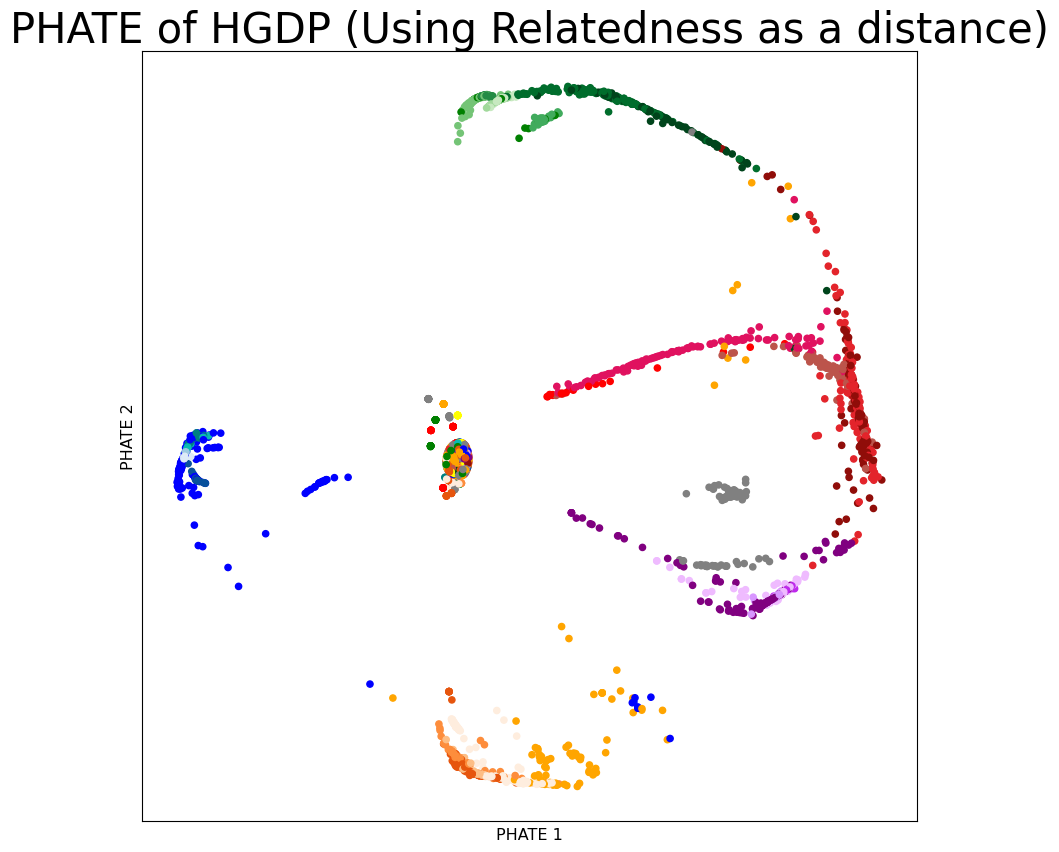

In [22]:
phate_operator = phate.PHATE(random_state=42, knn=5, t=5, knn_dist='precomputed_affinity')
phate_emb = phate_operator.fit_transform(relatedness_full_mat[king_mat_filtered_indices][:,king_mat_filtered_indices])

fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

# PCA
scprep.plot.scatter2d(phate_emb, 
                      s=20, 
                      cmap=pop_palette_hgdp_fine, ax=ax,
                      c=merged_metadata.loc[king_mat_filtered_indices]['Population'].values, 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)
ax.set_title("PHATE of HGDP (Using Relatedness as a distance)", fontsize=30)
ax.get_legend().remove()